### prev_application 데이터 세트 기반의 EDA와 Feature Engineering 수행 후 학습 모델 생성/평가

#### 라이브러리 및 데이터 세트 로딩. 이전 application 데이터의 FE 함수 복사

In [2]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

## 실무에서는 함수처리하면 누구나 쉽게 이용가능 해서 함수화처리가 필수이다.

##### 코랩 버전은 Google Drive에서 데이터 세트를 로딩

In [3]:
app_train = pd.read_csv('dataset/home-credit-default-risk/application_train.csv')
app_test = pd.read_csv('dataset/home-credit-default-risk/application_test.csv')

In [12]:
def get_apps_dataset():
    app_train = pd.read_csv('dataset/home-credit-default-risk/application_train.csv')
    app_test = pd.read_csv('dataset/home-credit-default-risk/application_test.csv')
    
    # 두개의 csv를 concat 합쳐준다. 
    # merge와 concat 차이점 타켓값이 없어도 된다.
    apps = pd.concat([app_train, app_test])
     
    return apps

apps = get_apps_dataset()

In [11]:
def get_apps_dataset():
    default_dir = "/content/gdrive/My Drive"
    app_train = pd.read_csv(os.path.join(default_dir, 'application_train.csv'))
    app_test = pd.read_csv(os.path.join(default_dir, 'application_test.csv'))
    apps = pd.concat([app_train, app_test])
    
    return apps

apps = get_apps_dataset()
    

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive\\application_train.csv'

#### 이전 application 데이터의 feature engineering 함수 복사

In [13]:
# 뒤에서 쓸예정
def get_apps_processed(apps):
    
    # EXT_SOURCE_X FEATURE 가공
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

##### previous 데이터 로딩

In [14]:

prev = pd.read_csv('dataset/home-credit-default-risk/previous_application.csv')
print(prev.shape, apps.shape)

(1670214, 37) (356255, 122)


##### application와 previous outer 조인하고 누락된 집합들 확인. 

###### pd.merge(left, right, # merge할 DataFrame 객체 이름
-             how='inner', # left, rigth, inner (default), outer
-             on=None, # merge의 기준이 되는 Key 변수
-             left_on=None, # 왼쪽 DataFrame의 변수를 Key로 사용
-             right_on=None, # 오른쪽 DataFrame의 변수를 Key로 사용
-             left_index=False, # 만약 True 라면, 왼쪽 DataFrame의 index를 merge Key로 사용
-             right_index=False, # 만약 True 라면, 오른쪽 DataFrame의 index를 merge Key로 사용
-            sort=True, # merge 된 후의 DataFrame을 join Key 기준으로 정렬
-             suffixes=('_x', '_y'), # 중복되는 변수 이름에 대해 접두사 부여 (defaults to '_x', '_y'
-             copy=True, # merge할 DataFrame을 복사
-             indicator=False) # 병합된 이후의 DataFrame에 left_only, right_only, both 등의 출처를 알 수 있는 부가 정보 변수 추가

In [15]:
# previous와 applications를 양쪽 OUTER 조인하여 조인이 안되는 대상 조사
# pandas merge()시 인자로 indicator=True 부여하면 어느 집합이 조인에서 누락되는지 알수 있음.
# 37 + 122 -1(타켓값)
prev_app_outer = prev.merge(apps['SK_ID_CURR'], on='SK_ID_CURR', how='outer', indicator=True) 
#indicator=False) # 병합된 이후의 DataFrame에 left_only, right_only, both 등의 출처를 알 수 있는 부가 정보 변수 추가
prev_app_outer.head(10)



,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,_merge
0,2030495.0,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15.0,Y,1.0,0.000000,0.182832,0.867336,XAP,Approved,-73.0,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35.0,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,both
1,1696966.0,271877,Consumer loans,68258.655,1800000.0,1754721.0,180000.0,1800000.0,SATURDAY,18.0,Y,1.0,0.101325,NaN,NaN,XAP,Refused,-472.0,Cash through the bank,SCO,NaN,Repeater,Clothing and Accessories,POS,XNA,Regional / Local,55.0,Furniture,36.0,low_normal,POS industry with interest,NaN,NaN,NaN,NaN,NaN,NaN,both
2,2154916.0,271877,Consumer loans,12417.390,108400.5,119848.5,0.0,108400.5,SUNDAY,14.0,Y,1.0,0.000000,NaN,NaN,XAP,Approved,-548.0,Cash through the bank,XAP,NaN,New,Furniture,POS,XNA,Stone,196.0,Furniture,12.0,middle,POS industry with interest,365243.0,-512.0,-182.0,-392.0,-387.0,0.0,both
3,2802425.0,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11.0,Y,1.0,NaN,NaN,NaN,XNA,Approved,-164.0,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1.0,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,both
4,1536272.0,108129,Cash loans,21709.125,450000.0,512370.0,NaN,450000.0,WEDNESDAY,9.0,Y,1.0,NaN,NaN,NaN,XNA,Approved,-515.0,XNA,XAP,NaN,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),6.0,XNA,36.0,low_normal,Cash X-Sell: low,365243.0,-485.0,565.0,-155.0,-147.0,1.0,both
5,2068863.0,108129,Consumer loans,4830.930,47250.0,23688.0,24750.0,47250.0,THURSDAY,11.0,Y,1.0,0.556485,NaN,NaN,XAP,Approved,-619.0,Cash through the bank,XAP,Family,Repeater,Audio/Video,POS,XNA,Stone,110.0,Consumer electronics,6.0,high,POS household with interest,365243.0,-588.0,-438.0,-588.0,-580.0,0.0,both
6,2551979.0,108129,Consumer loans,6664.275,71352.0,71352.0,0.0,71352.0,WEDNESDAY,9.0,Y,1.0,0.000000,NaN,NaN,XAP,Approved,-1208.0,Cash through the bank,XAP,Unaccompanied,New,Consumer Electronics,POS,XNA,Stone,108.0,Furniture,12.0,low_normal,POS industry with interest,365243.0,-1176.0,-846.0,-846.0,-840.0,0.0,both
7,2517198.0,108129,Revolving loans,11250.000,0.0,225000.0,NaN,NaN,TUESDAY,13.0,Y,1.0,NaN,NaN,NaN,XAP,Approved,-957.0,XNA,XAP,NaN,Repeater,XNA,Cards,x-sell,Contact center,-1.0,XNA,0.0,XNA,Card X-Sell,-713.0,-673.0,365243.0,-461.0,-61.0,0.0,both
8,1760610.0,108129,Consumer loans,8593.965,33052.5,33052.5,0.0,33052.5,SUNDAY,10.0,Y,1.0,0.000000,NaN,NaN,XAP,Approved,-819.0,Cash through the bank,XAP,Unaccompanied,Repeater,Computers,POS,XNA,Stone,108.0,Furniture,4.0,low_action,POS industry with interest,365243.0,-783.0,-693.0,-753.0,-748.0,0.0,both
9,2523466.0,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11.0,Y,1.0,NaN,NaN,NaN,XNA,Approved,-301.0,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1.0,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,both


In [16]:
#_merge == merge 하고난 후 공통인 행 , 공통이지 않은 행(right_only ,left_only)
# prev_app_outer에 _merge라는 컬럼은 없다.
prev_app_outer['_merge'].value_counts()

both          1670214
right_only      17398
left_only           0
Name: _merge, dtype: int64

In [17]:
prev_app_outer.shape

(1687612, 38)

### previous 컬럼 설명

|Table|컬럼명|컬럼 대분류|컬럼 중분류|컬럼 설명|
|------|--------|----|--------|-----------------|
|previous_application.csv|SK_ID_PREV |대출|고유ID|과거 대출 고유 ID|
|previous_application.csv|SK_ID_CURR|대출|고유ID|현재 대출 고유 ID|
|previous_application.csv|NAME_CONTRACT_TYPE|대출|대출 유형|대출 유형|
|previous_application.csv|AMT_ANNUITY|대출|대출 금액|월 대출 지급액|
|previous_application.csv|AMT_APPLICATION|대출|대출 금액|대출 신청 금액|
|previous_application.csv|AMT_CREDIT|대출|대출 금액|대출금액(허가)|
|previous_application.csv|AMT_DOWN_PAYMENT|대출|대출 금액|대출 시 납부한 선금액|
|previous_application.csv|AMT_GOODS_PRICE|대출|대출 금액|소비자 대출상품액|
|previous_application.csv|WEEKDAY_APPR_PROCESS_START|고객|행동|대출 신청 시작 요일|
|previous_application.csv|HOUR_APPR_PROCESS_START|고객|행동|대출 신청 시작 시간대|
|previous_application.csv|FLAG_LAST_APPL_PER_CONTRACT|고객|행동|이전 계약의 마지막 대출 신청 여부|
|previous_application.csv|NFLAG_LAST_APPL_IN_DAY|고객|행동|하루중 마지막 대출 신청 여부(하루에 여러 번 대출 신청했을 경우)|
|previous_application.csv|NFLAG_MICRO_CASH|대출|대출 유형|소액 대출 여부|
|previous_application.csv|RATE_DOWN_PAYMENT|대출|대출 금액|선금 비율(정규화됨)|
|previous_application.csv|RATE_INTEREST_PRIMARY|대출|대출 금액|이자율|
|previous_application.csv|RATE_INTEREST_PRIVILEGED|대출|대출 금액|이자율|
|previous_application.csv|NAME_CASH_LOAN_PURPOSE|대출|대출 유형|현금 대출 목적|
|previous_application.csv|NAME_CONTRACT_STATUS|대출|대출 상태|대출 상태(허가, 취소)|
|previous_application.csv|DAYS_DECISION|대출|대출 상태|과거 신청 대비 현재 신청 결정 기간|
|previous_application.csv|NAME_PAYMENT_TYPE|대출|대출 유형|과거 대출 신청의 납부 방법|
|previous_application.csv|CODE_REJECT_REASON|대출|대출 상태|과거 신청 거절 사유|
|previous_application.csv|NAME_TYPE_SUITE|고객|행동(추천)|동행 고객|
|previous_application.csv|NAME_CLIENT_TYPE|고객|행동|신규 고객 또는 기존 대출 고객 여부|
|previous_application.csv|NAME_GOODS_CATEGORY|대출|대출 유형|대출 상품 중분류 유형|
|previous_application.csv|NAME_PORTFOLIO|대출|대출 유형|현금대출/POS/CAR 대출 유형|
|previous_application.csv|NAME_PRODUCT_TYPE|채널|판매 유형|고객이 찾아온 대출인가, 영업 대출인가|
|previous_application.csv|CHANNEL_TYPE|채널|채널 유형|채널 유형|
|previous_application.csv|SELLERPLACE_AREA|채널|채널 유형|판매자 판매 지역|
|previous_application.csv|NAME_SELLER_INDUSTRY|채널|채널 유형|판매자 Industry|
|previous_application.csv|CNT_PAYMENT|대출|대출 금액|이전 대출 신청의 대출금액 관련 Term|
|previous_application.csv|NAME_YIELD_GROUP|대출|대출 금액|집단 금리 적용 유형|
|previous_application.csv|PRODUCT_COMBINATION|대출|대출 유형|이전 대출 결합 상품|
|previous_application.csv|DAYS_FIRST_DRAWING|대출|상태|신청날짜부터 최초 대출 지급까지의 일자|
|previous_application.csv|DAYS_FIRST_DUE|대출|상태|신청날짜부터 마감일까지의 일자|
|previous_application.csv|DAYS_LAST_DUE_1ST_VERSION|대출|상태|신청날짜부터 첫 만기일까지의 일자|
|previous_application.csv|DAYS_LAST_DUE|대출|상태|신청날짜부터 마지막 만기일까지의 일자|
|previous_application.csv|DAYS_TERMINATION|대출|상태|현 대출 신청일자 대비 대출 예상 종료 일자|
|previous_application.csv|NFLAG_INSURED_ON_APPROVAL|대출|상태|대출 신청 시 보험가입 요청여부|


##### previous 컬럼과 Null 값 조사 

In [31]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 43 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

### 주요 컬럼 EDA 수행

##### SK_ID_CURR당 평균 SK_ID_PREV 건수 구하기
* groupby 로 평균 건수 구함. 
* boxplot으로 시각화

In [18]:
# SK_ID_CURR 로 groupby하여 평균 건수 구함.
#현재 대출 고유 ID == SK_ID_CURR
prev.groupby('SK_ID_CURR')['SK_ID_CURR'].count().mean()
# 한사람이 몇번을 대출 했는지 횟수를 평균을 낸다

4.928964135313716

<AxesSubplot:xlabel='SK_ID_CURR'>

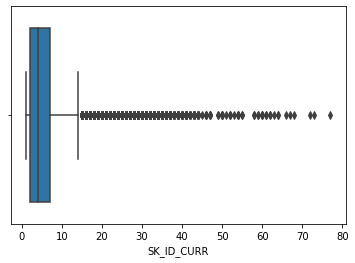

In [19]:
# box plot으로 시각화. 일부 데이터는 특정 SK_ID_CURR로 몇십개의 데이터가 있음.
sns.boxplot(prev.groupby('SK_ID_CURR')['SK_ID_CURR'].count())
#10번 이하인 사람이 대부분이다.

#### 숫자형 피처들의 Histogram을 TARGET 유형에 따라 비교

* application_train의 TARGET 값을 가져오기 위해 prev와 app_train을 inner join 후 TARGET 유형에 따라 비교
* 숫자형 컬럼명 필터링

In [20]:
# SK_ID_CURR은 prev에 가지고 있고 on을 줬기 떄문에 target컬럼만 추가 된다.
app_prev = prev.merge(app_train[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
app_prev.shape


(1670214, 38)

In [21]:
# int, folat 형인 값들만 바이올릿 플랏과 히스토그램으로 target을 기준으로 시각화
def show_hist_by_target(df, columns):
    cond_1 = (df['TARGET'] == 1) # 돈을 안값는 사람
    cond_0 = (df['TARGET'] == 0) # 돈을 갚은 사람 
    
    for column in columns:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), squeeze=False)
        sns.violinplot(x='TARGET', y=column, data=df, ax=axs[0][0] )
        sns.distplot(df[cond_0][column], ax=axs[0][1], label='0', color='blue')
        sns.distplot(df[cond_1][column], ax=axs[0][1], label='1', color='red')   

In [22]:
# 오브젝트가 아닌 값들 중 ['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']] 이 세개는 뺴고 출력
num_columns = app_prev.dtypes[app_prev.dtypes != 'object'].index.tolist()
num_columns = [column for column in num_columns if column not in['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']]
print(num_columns)
# num_columns = 35개의 컬럼값 

['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']


KeyboardInterrupt: 

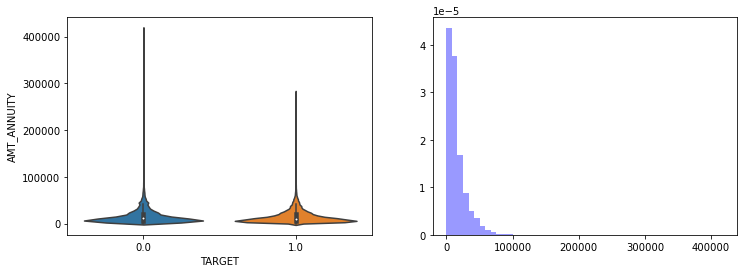

In [23]:
show_hist_by_target(app_prev, num_columns)

* AMT_ANNUITY, AMT_CREDIT, AMT_APPLICATION, AMT_GOODS_CREDIT는 TARGET=1일 경우에 소액 비율이 약간 높음(큰 차이는 아님)
* RATE_DOWN_PAYMENT는 큰 차이 없음. 
* RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED 는 NULL값이 매우 많아서 판단 어려움
* DAYS_DECISION은 TARGET=1일 때 0에 가까운(최근일)값이 약간 더 많음. 
* DAYS_FIRST_DRAWING, DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, DAYS_TERMINATION은 365243 값이 매우 많음. 

#### Category 피처들의 Histogram을 TARGET 유형에 따라 비교

In [ ]:
object_columns = app_prev.dtypes[app_prev.dtypes=='object'].index.tolist()
object_columns

KeyboardInterrupt: 

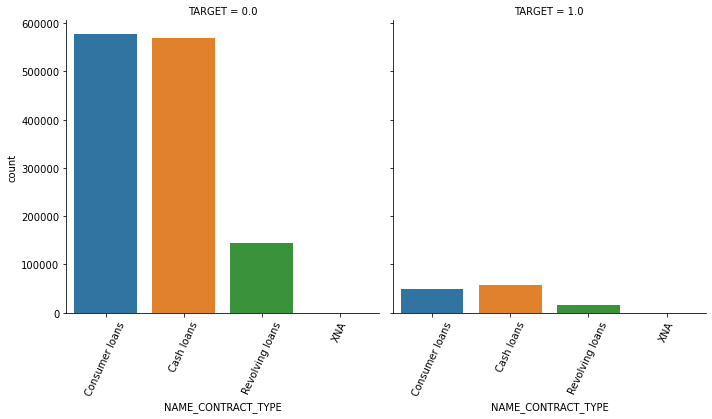

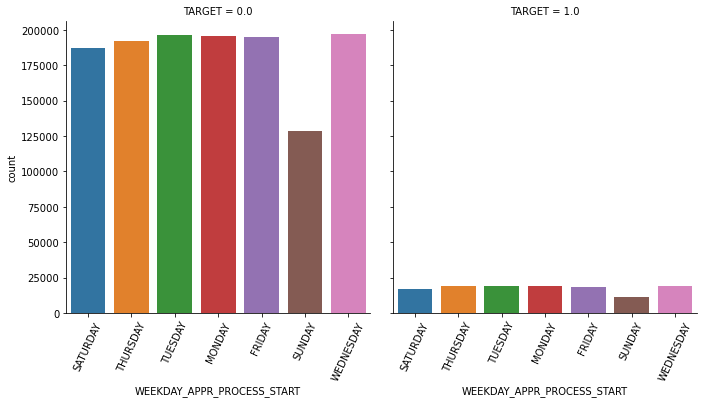

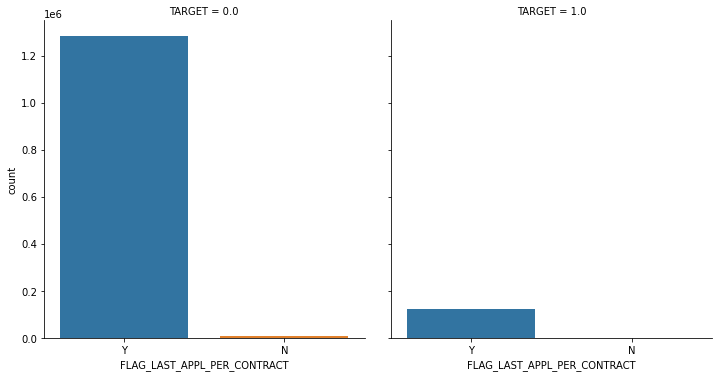

In [17]:
# 오브젝트(스털링) 인 컬럼만 뽑아서 target을 기준으로 시각화 하기 
# 넘  오래 걸려용
def show_category_by_target(df, columns):
    for column in columns:
        chart = sns.catplot(x=column, col="TARGET", data=df, kind="count")
        chart.set_xticklabels(rotation=65) # x축 레이블값이 너무 길어서 각도를 65도 처리 하였다
        
show_category_by_target(app_prev, object_columns)

* NAME_CONTRACT_TYPE은 TARGET=1일때 CASH_LOAN의 비중이 약간 높음
* NAME_CONTRACT_STATUS(대출허가상태)는 TARGET=1일때 상대적으로 TARGET=0 대비 (당연히) Refused의 비율이 높음. 
* NAME_PAYMENT_TYPE(대출납부방법)는 TARGET=1일때 상대적으로 TARGET=0 대비 XNA의 비율이 약간 높음.

### prev 데이터 세트 feature engineering 수행. 
#### SQL 대비  Pandas groupby 사용 로직 비교

##### SQL로 SK_ID_CURR별 건수, 평균 AMT_CREDIT, 최대 AMT_CREDIT, 최소 AMT_CREDIT 구하기

In [ ]:
# select sk_id_curr, count(*), avg(amt_credit) , max(amt_credit), min(amt_credit) from previous group by sk_id_curr

##### pandas groupby 단일 aggregation 함수 사용
* groupby SK_ID_CURR
* SK_ID_CURR별 건수, AMT_CREDIT에 대한 평균, 최대 값

In [38]:
prev.groupby('SK_ID_CURR')

In [39]:
# DataFrameGroupby 생성.
# 그룹바이 판다스로 만들기 1 기초
prev_group= prev.groupby('SK_ID_CURR')
# DataFrameGroupby 객체에 aggregation함수 수행 결과를 저장한 DataFrame 생성 및 aggregation값 저장.
prev_agg = pd.DataFrame()
prev_agg['CNT'] = prev_group['SK_ID_CURR'].count() # count하면서 prev_group의 인덱스도 같이 넘어가는듯 하다
prev_agg['AVG_CREDIT'] = prev_group['AMT_CREDIT'].mean() # 전체 대출 금액 평균 
prev_agg['MAX_CREDIT'] = prev_group['AMT_CREDIT'].max()  # 빌렸던 대출 중에서 최고액
# groupby 컬럼값이 DataFrame의 Index가 됨. 컬럼으로 변환하려면 reset_index()로 변환 필요.
prev_agg.head(10)


,CNT,AVG_CREDIT,MAX_CREDIT
SK_ID_CURR,,,
100001,1,23787.000000,23787.0
100002,1,179055.000000,179055.0
100003,3,484191.000000,1035882.0
100004,1,20106.000000,20106.0
100005,2,20076.750000,40153.5
100006,9,291695.500000,906615.0
100007,6,166638.750000,284400.0
100008,5,162767.700000,501975.0
100009,7,70137.642857,98239.5


##### groupby agg()함수를 이용하여 여러개의 aggregation 함수 적용

In [40]:
# 그룹바이 판다스로 만들기 2 중급
prev_group = prev.groupby('SK_ID_CURR')
# DataFrameGroupby의 agg() 함수를 이용하여 여러개의 aggregation 함수 적용
prev_agg1 = prev_group['AMT_CREDIT'].agg(['mean', 'max', 'sum'])
prev_agg2 = prev_group['AMT_ANNUITY'].agg(['mean', 'max', 'sum'])
# merge를 이용하여 두개의 DataFrame 결합.
prev_agg = prev_agg1.merge(prev_agg2, on='SK_ID_CURR', how='inner')
prev_agg.head(10)


,mean_x,max_x,sum_x,mean_y,max_y,sum_y
SK_ID_CURR,,,,,,
100001,23787.000000,23787.0,23787.0,3951.000000,3951.000,3951.000
100002,179055.000000,179055.0,179055.0,9251.775000,9251.775,9251.775
100003,484191.000000,1035882.0,1452573.0,56553.990000,98356.995,169661.970
100004,20106.000000,20106.0,20106.0,5357.250000,5357.250,5357.250
100005,20076.750000,40153.5,40153.5,4813.200000,4813.200,4813.200
100006,291695.500000,906615.0,2625259.5,23651.175000,39954.510,141907.050
100007,166638.750000,284400.0,999832.5,12278.805000,22678.785,73672.830
100008,162767.700000,501975.0,813838.5,15839.696250,25309.575,63358.785
100009,70137.642857,98239.5,490963.5,10051.412143,17341.605,70359.885


##### agg()에 dictionary를 이용하여 groupby 적용

In [41]:
# 이게 가장 최고 방법이다.
# 그룹바이 판다스로 만들기 3 고급

# 딕셔너리 키값이 멀티 인뎃스 부모 
# 딕셔너리 벨류 값이 멀티인덱스 자식들 
agg_dict = {
'SK_ID_CURR':['count'],
'AMT_CREDIT':['mean', 'max', 'sum'],
'AMT_ANNUITY':['mean', 'max', 'sum'],
'AMT_APPLICATION':['mean', 'max', 'sum'],
'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
'AMT_GOODS_PRICE':['mean', 'max', 'sum']
}
prev_group = prev.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)
prev_amt_agg.head()
# 위처러  딕셔너리를 쓰면 컬럼층이 2개가 된다. 
# 층이 2개면 관리가 어렵다.


SK_ID_CURR AMT_CREDIT                       AMT_ANNUITY             \
                count       mean        max        sum        mean        max   
SK_ID_CURR                                                                      
100001              1   23787.00    23787.0    23787.0    3951.000   3951.000   
100002              1  179055.00   179055.0   179055.0    9251.775   9251.775   
100003              3  484191.00  1035882.0  1452573.0   56553.990  98356.995   
100004              1   20106.00    20106.0    20106.0    5357.250   5357.250   
100005              2   20076.75    40153.5    40153.5    4813.200   4813.200   

                       AMT_APPLICATION                      AMT_DOWN_PAYMENT  \
                   sum            mean       max        sum             mean   
SK_ID_CURR                                                                     
100001        3951.000        24835.50   24835.5    24835.5           2520.0   
100002        9251.775       179055.00  179055.0   179055.0              0.0   
100003      169661.970       435436.50  900000.0  1306309.5           3442.5   
100004        5357.250        24282.00   24282.0    24282.0           4860.0   
100005        4813.200        22308.75   44617.5    44617.5           4464.0   

                           AMT_GOODS_PRICE                       
               max     sum            mean       max        sum  
SK_ID_CURR                                                       
100001      2520.0  2520.0         24835.5   24835.5    24835.5  
100002         0.0     0.0        179055.0  179055.0   179055.0  
100003      6885.0  6885.0        435436.5  900000.0  1306309.5  
100004      4860.0  4860.0         24282.0   24282.0    24282.0  
100005      4464.0  4464.0         44617.5   44617.5    44617.5

##### grouby agg 로 만들어진  Multi index 컬럼 변경. 
* MultiIndex로 되어 있는 컬럼명 확인
* MultiIndex 컬럼명을 _로 연결하여 컬럼명 변경. 

In [42]:
prev_amt_agg.columns
# 컬럼들을 뽑으면 컬럼은 자식커럼 갯수 만큼 나온다,

MultiIndex([(      'SK_ID_CURR', 'count'),
            (      'AMT_CREDIT',  'mean'),
            (      'AMT_CREDIT',   'max'),
            (      'AMT_CREDIT',   'sum'),
            (     'AMT_ANNUITY',  'mean'),
            (     'AMT_ANNUITY',   'max'),
            (     'AMT_ANNUITY',   'sum'),
            ( 'AMT_APPLICATION',  'mean'),
            ( 'AMT_APPLICATION',   'max'),
            ( 'AMT_APPLICATION',   'sum'),
            ('AMT_DOWN_PAYMENT',  'mean'),
            ('AMT_DOWN_PAYMENT',   'max'),
            ('AMT_DOWN_PAYMENT',   'sum'),
            ( 'AMT_GOODS_PRICE',  'mean'),
            ( 'AMT_GOODS_PRICE',   'max'),
            ( 'AMT_GOODS_PRICE',   'sum')],
           )

In [43]:
# 2층 구조인 컬럼의 0과 1자리를 붙혀준다 
#그럼 밑에처럼 상위층컬럼이 나오고 하위 컬럼이 나온다. 
[column[0]+column[1] for column in prev_amt_agg.columns]


['SK_ID_CURRcount',
 'AMT_CREDITmean',
 'AMT_CREDITmax',
 'AMT_CREDITsum',
 'AMT_ANNUITYmean',
 'AMT_ANNUITYmax',
 'AMT_ANNUITYsum',
 'AMT_APPLICATIONmean',
 'AMT_APPLICATIONmax',
 'AMT_APPLICATIONsum',
 'AMT_DOWN_PAYMENTmean',
 'AMT_DOWN_PAYMENTmax',
 'AMT_DOWN_PAYMENTsum',
 'AMT_GOODS_PRICEmean',
 'AMT_GOODS_PRICEmax',
 'AMT_GOODS_PRICEsum']

In [44]:
# 이처럼 하면 된다는 예를 든것
('_').join(['test01','test2'])
# test사이에 _를 추가한다. 

'test01_test2'

##### prev 피처 가공. 대출 신청액 대비 다른 금액 차이 및 비율 생성. 

In [45]:
prev_amt_agg.columns.ravel()

array([('SK_ID_CURR', 'count'), ('AMT_CREDIT', 'mean'),
       ('AMT_CREDIT', 'max'), ('AMT_CREDIT', 'sum'),
       ('AMT_ANNUITY', 'mean'), ('AMT_ANNUITY', 'max'),
       ('AMT_ANNUITY', 'sum'), ('AMT_APPLICATION', 'mean'),
       ('AMT_APPLICATION', 'max'), ('AMT_APPLICATION', 'sum'),
       ('AMT_DOWN_PAYMENT', 'mean'), ('AMT_DOWN_PAYMENT', 'max'),
       ('AMT_DOWN_PAYMENT', 'sum'), ('AMT_GOODS_PRICE', 'mean'),
       ('AMT_GOODS_PRICE', 'max'), ('AMT_GOODS_PRICE', 'sum')],
      dtype=object)

In [46]:
# multi index 컬럼을 '_'로 연결하여 컬럼명 변경  


# !ravel  알아보기 다차원을 1차원을로 만들어준다
# x = np.array([[1, 2, 3], [4, 5, 6]])
#      np.ravel(x)
#      array([1, 2, 3, 4, 5, 6])
#prev_amt_agg.columns의 경우 ('AMT_DOWN_PAYMENT',  'mean') 한 튜플안에 있기 때문에 하나의 튜플을 하나의 리스트로 만들게 된다.

#밑에 for 문을 보면 리스트 튜플 하나가 리스트가 되어 두개 원소(상위컬럼,하위컬럼) 사이에 _가 붙는다.
prev_amt_agg.columns = ["PREV_"+"_".join(x).upper() for x in prev_amt_agg.columns.ravel()] #ravel 을 쓰게되면, in
prev_amt_agg.columns

Index(['PREV_SK_ID_CURR_COUNT', 'PREV_AMT_CREDIT_MEAN', 'PREV_AMT_CREDIT_MAX',
       'PREV_AMT_CREDIT_SUM', 'PREV_AMT_ANNUITY_MEAN', 'PREV_AMT_ANNUITY_MAX',
       'PREV_AMT_ANNUITY_SUM', 'PREV_AMT_APPLICATION_MEAN',
       'PREV_AMT_APPLICATION_MAX', 'PREV_AMT_APPLICATION_SUM',
       'PREV_AMT_DOWN_PAYMENT_MEAN', 'PREV_AMT_DOWN_PAYMENT_MAX',
       'PREV_AMT_DOWN_PAYMENT_SUM', 'PREV_AMT_GOODS_PRICE_MEAN',
       'PREV_AMT_GOODS_PRICE_MAX', 'PREV_AMT_GOODS_PRICE_SUM'],
      dtype='object')

In [47]:
# 멀티 인덱스의 부모와 자식을 join으로 붙혀주었다.
prev_amt_agg.head()

,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,
100001,1,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,2520.0,2520.0,2520.0,24835.5,24835.5,24835.5
100002,1,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775,179055.00,179055.0,179055.0,0.0,0.0,0.0,179055.0,179055.0,179055.0
100003,3,484191.00,1035882.0,1452573.0,56553.990,98356.995,169661.970,435436.50,900000.0,1306309.5,3442.5,6885.0,6885.0,435436.5,900000.0,1306309.5
100004,1,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250,24282.00,24282.0,24282.0,4860.0,4860.0,4860.0,24282.0,24282.0,24282.0
100005,2,20076.75,40153.5,40153.5,4813.200,4813.200,4813.200,22308.75,44617.5,44617.5,4464.0,4464.0,4464.0,44617.5,44617.5,44617.5


#### prev 피처 가공. 대출 신청액 대비 다른 금액 차이 및 비율 생성.


In [48]:
# 대출 신청 금액과 실제 대출액/대출 상품금액 차이 및 비율
prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT'] #대출 신청 금액 -  대출금액(허가)

prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE'] #대출 신청 금액 - 소비자 대출상품액

prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']  # 수압 / 대출 금액
prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION'] # 월 대출 지급액  / 대출 금액
prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']


##### DAYS_XXX 피처의 365243 을 NULL로 변환하고, 첫번째 만기일과 마지막 만기일까지의 기간 가공

In [49]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
# 첫번째 만기일과 마지막 만기일까지의 기간
prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']


##### 기존 이자율 관련 컬럼이 null이 많아서 새롭게 간단한 이자율을 대출 금액과 대출 금액 납부 횟수를 기반으로 계산 

In [50]:
# 매월 납부 금액과 납부 횟수 곱해서 전체 납부 금액 구함.
all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
# 전체 납부 금액 대비 AMT_CREDIT 비율을 구하고 여기에 다시 납부횟수로 나누어서 이자율 계산.
prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

##### 기존 대출 금액, 대출 상태 관련 피처들과 이들을 가공하여 만들어진 새로운 컬럼들로 aggregation 수행.

In [51]:
# DAYS_FIRST_DRAWING = 직장 다닌 일수   365243는 1000천년이긴 때문에 연금을 타는 이상치이다
# 365243는 non값으로 바꿔준다
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True) 
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
# 첫번째 만기일과 마지막 만기일까지의 기간
prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']


In [52]:
prev.iloc[:, -7:].head(10)

,PREV_CREDIT_DIFF,PREV_GOODS_DIFF,PREV_CREDIT_APPL_RATIO,PREV_GOODS_APPL_RATIO,PREV_DAYS_LAST_DUE_DIFF,PREV_INTERESTS_RATE,PREV_ANNUITY_APPL_RATIO
0,0.0,0.0,1.000000,1.0,342.0,0.017596,0.100929
1,-72171.0,0.0,1.118800,1.0,NaN,0.009282,0.041463
2,-23944.5,0.0,1.212840,1.0,NaN,0.027047,0.133873
3,-20790.0,0.0,1.046200,1.0,30.0,0.016587,0.104536
4,-66555.0,0.0,1.197200,1.0,NaN,0.037343,0.094591
5,-25573.5,0.0,1.081186,1.0,0.0,0.014044,0.075251
6,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,NaN,NaN,NaN,NaN,NaN,NaN


##### 기존 대출 금액, 대출 상태 관련 피처들과 이들을 가공하여 만들어진 새로운 컬럼들로 aggregation 수행.


In [53]:
# 새롭게 생성된 대출 신청액 대비 다른 금액 차이 및 비율로 aggregation 수행.
# 다시 pred를 다시 그룹바이 한다. 
agg_dict = {

    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'],
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],

    'PREV_CREDIT_DIFF':['mean', 'max', 'sum'],
    'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
    'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
    'PREV_GOODS_APPL_RATIO':['mean', 'max'],
    'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
    'PREV_INTERESTS_RATE':['mean', 'max']
}
prev_group = prev.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)

# multi index 컬럼을 '_'로 연결하여 컬럼명 변경

prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]


In [54]:
print(prev_amt_agg.shape)
prev_amt_agg.head()

(338857, 39)


,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,1,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,2520.0,2520.0,2520.0,24835.5,24835.5,24835.5,0.104326,0.104326,0.104326,-1740,-1740,-1740.0,8.0,8.0,1048.5,1048.5,1048.5,0.957782,0.957782,0.0,0.0,0.0,1.0,1.0,120.0,120.0,120.0,0.041099,0.041099
100002,1,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775,179055.00,179055.0,179055.0,0.0,0.0,0.0,179055.0,179055.0,179055.0,0.000000,0.000000,0.000000,-606,-606,-606.0,24.0,24.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,150.0,150.0,150.0,0.010003,0.010003
100003,3,484191.00,1035882.0,1452573.0,56553.990,98356.995,169661.970,435436.50,900000.0,1306309.5,3442.5,6885.0,6885.0,435436.5,900000.0,1306309.5,0.000000,0.100061,0.050030,-2341,-746,-1305.0,10.0,30.0,-48754.5,756.0,-146263.5,1.057664,1.150980,0.0,0.0,0.0,1.0,1.0,50.0,150.0,150.0,0.015272,0.018533
100004,1,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250,24282.00,24282.0,24282.0,4860.0,4860.0,4860.0,24282.0,24282.0,24282.0,0.212008,0.212008,0.212008,-815,-815,-815.0,4.0,4.0,4176.0,4176.0,4176.0,0.828021,0.828021,0.0,0.0,0.0,1.0,1.0,30.0,30.0,30.0,0.016450,0.016450
100005,2,20076.75,40153.5,40153.5,4813.200,4813.200,4813.200,22308.75,44617.5,44617.5,4464.0,4464.0,4464.0,44617.5,44617.5,44617.5,0.108964,0.108964,0.108964,-757,-315,-536.0,12.0,12.0,2232.0,4464.0,4464.0,0.899950,0.899950,0.0,0.0,0.0,1.0,1.0,90.0,90.0,90.0,0.036537,0.036537


#### SK_ID_CURR별로 NAME_CONTRACT_STATUS가 Refused 일 경우의 건수 및 과거 대출건 대비 비율

#### Group by 기준  컬럼 기반에서 다른 컬럼들의 기준에 따라 세분화된 aggregation 수행. 

In [55]:
prev['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

##### SQL Group by Case when 과 pandas의 차이

In [36]:
# SK_ID_CURR레벨로 groupby 된 count와  name_contract_status가 Refused일 때의 count 
'''select sk_id_curr, cnt_refused/cnt
from
(
    select sk_id_curr, count(*) cnt, count(case when name_contract_status == 'Refused' end) cnt_refused
    from previous group by sk_id_curr
) 
'''

"select sk_id_curr, cnt_refused/cnt\nfrom\n(\n    select sk_id_curr, count(*) cnt, count(case when name_contract_status == 'Refused' end) cnt_refused\n    from previous group by sk_id_curr\n) \n"

##### Pandas는 원 DataFrame 에 groupby 적용된 DataFrame 과 세부기준으로 filtering 된 DataFrame에 groupby 적용된 DataFrame 을 조인하여 생성. 
* NAME_CONTRACT_STATUS == 'Refused' 세부 기준으로 filtering 및 filtering 된 DataFrame에 groupby 적용 
* groupby 완료 후 기존 prev_amt_agg와 조인
* 효율적인 오류 방지를 위해서 groupby 시 적용후 groupby key값을 DataFrame의 Index가 아닌 일반 컬럼으로 변경.

In [56]:
# NAME_CONTRACT_STATUS == 'Refused' 세부 기준으로 filtering
cond_refused = (prev['NAME_CONTRACT_STATUS'] == 'Refused') # 대출 상태(허가, 거절, 취소)

prev_refused = prev[cond_refused]
prev_refused.shape, prev.shape


((290678, 44), (1670214, 44))

In [57]:
# NAME_CONTRACT_STATUS == 'Refused' 세부 기준으로 filtering 된 DataFrame에 groupby 적용
prev_refused_agg = prev_refused.groupby(['SK_ID_CURR'])['SK_ID_CURR'].count()
print(prev_amt_agg.shape, prev_refused_agg .shape)
prev_refused_agg.head(10)

(338857, 39) (118277,)


SK_ID_CURR
100006     1
100011     1
100027     1
100030    10
100035     8
100036     3
100037     2
100043     5
100046     1
100047     2
Name: SK_ID_CURR, dtype: int64

In [58]:
type(prev_refused.groupby(['SK_ID_CURR'])['SK_ID_CURR'].count())


pandas.core.series.Series

In [60]:
# prev_refused_agg은 Series객체이고 Index는 SK_ID_CURR, prev_amt_agg은 DataFrame, Index는 SK_ID_CURR. 하지만 JOIN되지 않는다.
# Series와 DataFrame 조인 시 Series를 DataFrame으로 내부 변환하는데 조인 시 Index명과 컬럼명이 서로 충돌하여 오류.
# merge는 컬럼끼리 하는 것인디 prev_refused_agg애서 SK_ID_CURR는 인덱스로 되어있기 때문에 에러가 뜬다.
prev_amt_refused_agg = prev_amt_agg.merge(prev_refused_agg, on='SK_ID_CURR', how='left')


# 에러가 뜸 

ValueError: 'SK_ID_CURR' is both an index level and a column label, which is ambiguous.

In [61]:
pd.DataFrame(prev_refused_agg)
# 데이터로 만들면 인덱스와 컬럼명이 같다. 
# count 컬럼명을 다른것으로 바꾸어 주어야 한다.

,SK_ID_CURR
SK_ID_CURR,
100006,1
100011,1
100027,1
100030,10
100035,8
...,...
456244,1
456247,1
456249,1


In [62]:
# count 컬럼명을 바꿔어 준다.
# --> prev_refused_agg.reset_index() 바로 reset_index를 하면 인덱스명과 컬럼명 같아서 충돌이 난다.


# 해결 방안
# 일반적으로 groupby key를 INDEX로 하는 것보다 일반 컬럼으로 하는 것이 여러가지 오류 예방에 효율적.
prev_refused_agg = prev_refused_agg.reset_index(name='PREV_REFUSED_COUNT')


In [63]:
prev_refused_agg

,SK_ID_CURR,PREV_REFUSED_COUNT
0,100006,1
1,100011,1
2,100027,1
3,100030,10
4,100035,8
...,...,...
118272,456244,1
118273,456247,1
118274,456249,1
118275,456250,1


####   컬럼명 바꾼 prev_refused_agg와 prev_amt_agg를 merge 기본키로 SK_ID_CURR하여 merge시킨다.

In [64]:
prev_amt_agg = prev_amt_agg.reset_index()
prev_amt_refused_agg = prev_amt_agg.merge(prev_refused_agg, on='SK_ID_CURR', how='left')
prev_amt_refused_agg.head()

,SK_ID_CURR,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_COUNT
0,100001,1,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,2520.0,2520.0,2520.0,24835.5,24835.5,24835.5,0.104326,0.104326,0.104326,-1740,-1740,-1740.0,8.0,8.0,1048.5,1048.5,1048.5,0.957782,0.957782,0.0,0.0,0.0,1.0,1.0,120.0,120.0,120.0,0.041099,0.041099,NaN
1,100002,1,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775,179055.00,179055.0,179055.0,0.0,0.0,0.0,179055.0,179055.0,179055.0,0.000000,0.000000,0.000000,-606,-606,-606.0,24.0,24.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,150.0,150.0,150.0,0.010003,0.010003,NaN
2,100003,3,484191.00,1035882.0,1452573.0,56553.990,98356.995,169661.970,435436.50,900000.0,1306309.5,3442.5,6885.0,6885.0,435436.5,900000.0,1306309.5,0.000000,0.100061,0.050030,-2341,-746,-1305.0,10.0,30.0,-48754.5,756.0,-146263.5,1.057664,1.150980,0.0,0.0,0.0,1.0,1.0,50.0,150.0,150.0,0.015272,0.018533,NaN
3,100004,1,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250,24282.00,24282.0,24282.0,4860.0,4860.0,4860.0,24282.0,24282.0,24282.0,0.212008,0.212008,0.212008,-815,-815,-815.0,4.0,4.0,4176.0,4176.0,4176.0,0.828021,0.828021,0.0,0.0,0.0,1.0,1.0,30.0,30.0,30.0,0.016450,0.016450,NaN
4,100005,2,20076.75,40153.5,40153.5,4813.200,4813.200,4813.200,22308.75,44617.5,44617.5,4464.0,4464.0,4464.0,44617.5,44617.5,44617.5,0.108964,0.108964,0.108964,-757,-315,-536.0,12.0,12.0,2232.0,4464.0,4464.0,0.899950,0.899950,0.0,0.0,0.0,1.0,1.0,90.0,90.0,90.0,0.036537,0.036537,NaN


##### 계산된 PREV_REFUSED_COUNT 중 Null값은 0 으로 변경하고 SK_ID_CURR 개별 건수 대비 PREV_REFUSED_COUNT 비율 계산

In [65]:
prev_amt_refused_agg['PREV_REFUSED_COUNT'].value_counts(dropna=False)
# NaN     220580개

NaN     220580
1.0      54616
2.0      26793
3.0      14025
4.0       8243
5.0       4859
6.0       3147
7.0       2069
8.0       1247
9.0        871
10.0       656
11.0       437
12.0       340
13.0       233
14.0       157
15.0       149
16.0        94
17.0        62
18.0        54
19.0        48
20.0        28
21.0        25
22.0        21
24.0        18
25.0        12
26.0        11
23.0        11
27.0         8
28.0         5
29.0         5
32.0         4
30.0         3
31.0         3
37.0         3
41.0         3
34.0         2
36.0         2
33.0         2
39.0         2
35.0         2
43.0         1
54.0         1
64.0         1
68.0         1
47.0         1
58.0         1
51.0         1
Name: PREV_REFUSED_COUNT, dtype: int64

In [66]:
# REFUSED_COUNT가 NaN인 데이터는 과거 대출신청시 Refused가 없는 것임. 따라서 0으로 치환해야함.
prev_amt_refused_agg['PREV_REFUSED_COUNT'] = prev_amt_refused_agg['PREV_REFUSED_COUNT'].fillna(0)
# SK_ID_CURR별 과거 대출건수 대비 REFUSED_COUNT 비율 생성.
prev_amt_refused_agg['PREV_REFUSED_RATIO'] = prev_amt_refused_agg['PREV_REFUSED_COUNT']/prev_amt_refused_agg['PREV_SK_ID_CURR_COUNT']


In [67]:
prev_amt_refused_agg.head(30)

,SK_ID_CURR,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_COUNT,PREV_REFUSED_RATIO
0,100001,1,23787.000000,23787.0,23787.000,3951.000000,3951.000,3951.000,24835.500000,24835.5,24835.500,2520.000000,2520.0,2520.00,24835.500000,24835.5,24835.500,0.104326,0.104326,0.104326,-1740,-1740,-1740.000000,8.000000,8.0,1048.500000,1048.5,1048.50,0.957782,0.957782,0.0,0.0,0.0,1.0,1.0,120.00,120.0,120.0,0.041099,0.041099,0.0,0.000000
1,100002,1,179055.000000,179055.0,179055.000,9251.775000,9251.775,9251.775,179055.000000,179055.0,179055.000,0.000000,0.0,0.00,179055.000000,179055.0,179055.000,0.000000,0.000000,0.000000,-606,-606,-606.000000,24.000000,24.0,0.000000,0.0,0.00,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,150.00,150.0,150.0,0.010003,0.010003,0.0,0.000000
2,100003,3,484191.000000,1035882.0,1452573.000,56553.990000,98356.995,169661.970,435436.500000,900000.0,1306309.500,3442.500000,6885.0,6885.00,435436.500000,900000.0,1306309.500,0.000000,0.100061,0.050030,-2341,-746,-1305.000000,10.000000,30.0,-48754.500000,756.0,-146263.50,1.057664,1.150980,0.0,0.0,0.0,1.0,1.0,50.00,150.0,150.0,0.015272,0.018533,0.0,0.000000
3,100004,1,20106.000000,20106.0,20106.000,5357.250000,5357.250,5357.250,24282.000000,24282.0,24282.000,4860.000000,4860.0,4860.00,24282.000000,24282.0,24282.000,0.212008,0.212008,0.212008,-815,-815,-815.000000,4.000000,4.0,4176.000000,4176.0,4176.00,0.828021,0.828021,0.0,0.0,0.0,1.0,1.0,30.00,30.0,30.0,0.016450,0.016450,0.0,0.000000
4,100005,2,20076.750000,40153.5,40153.500,4813.200000,4813.200,4813.200,22308.750000,44617.5,44617.500,4464.000000,4464.0,4464.00,44617.500000,44617.5,44617.500,0.108964,0.108964,0.108964,-757,-315,-536.000000,12.000000,12.0,2232.000000,4464.0,4464.00,0.899950,0.899950,0.0,0.0,0.0,1.0,1.0,90.00,90.0,90.0,0.036537,0.036537,0.0,0.000000
5,100006,9,291695.500000,906615.0,2625259.500,23651.175000,39954.510,141907.050,272203.260000,688500.0,2449829.340,34840.170000,66987.0,69680.34,408304.890000,688500.0,2449829.340,0.108994,0.217830,0.163412,-617,-181,-272.444444,23.000000,138.0,-19492.240000,66987.0,-175430.16,1.012684,1.316797,0.0,0.0,0.0,1.0,1.0,810.00,1410.0,1620.0,NaN,0.027424,1.0,0.111111
6,100007,6,166638.750000,284400.0,999832.500,12278.805000,22678.785,73672.830,150530.250000,247500.0,903181.500,3390.750000,3676.5,6781.50,150530.250000,247500.0,903181.500,0.100143,0.218890,0.159516,-2357,-374,-1222.833333,20.666667,124.0,-16108.500000,2560.5,-96651.00,1.046356,1.264000,0.0,0.0,0.0,1.0,1.0,7.50,30.0,30.0,0.026538,0.036164,0.0,0.000000
7,100008,5,162767.700000,501975.0,813838.500,15839.696250,25309.575,63358.785,155701.800000,450000.0,778509.000,5548.500000,12145.5,16645.50,194627.250000,450000.0,778509.000,0.000000,0.110243,0.073051,-2536,-82,-1192.000000,14.000000,56.0,-7065.900000,12145.5,-35329.50,0.978569,1.115500,0.0,0.0,0.0,1.0,1.0,165.00,660.0,660.0,0.018055,0.034034,0.0,0.000000
8,100009,7,70137.642857,98239.5,490963.500,10051.412143,17341.605,70359.885,76741.714286,110160.0,537192.000,9203.142857,22032.0,64422.00,76741.714286,1

##### 세부 레벨 groupby 와 unstack()을 이용하여 SQL Group by Case when 구현. 세부 조건이 2개 이상일때


###### SQL 일 경우
SELECT COUNT(CASE WHEN == 'Approved' END) , COUNT(CASE WHEN == 'Refused' END) FROM PREV GROUP BY SK_ID_CURR

##### Pandas로 수행

In [68]:
# 원래 groupby 컬럼 + 세부 기준 컬럼으로 groupby 수행. 세분화된 레벨로 aggregation 수행 한 뒤에 unstack()으로 컬럼레벨로 변형.
prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby(['SK_ID_CURR','NAME_CONTRACT_STATUS'])

In [69]:
prev_refused_appr_group['SK_ID_CURR'].count()


SK_ID_CURR  NAME_CONTRACT_STATUS
100001      Approved                1
100002      Approved                1
100003      Approved                3
100004      Approved                1
100005      Approved                1
                                   ..
456252      Approved                1
456253      Approved                2
456254      Approved                2
456255      Approved                6
            Refused                 2
Name: SK_ID_CURR, Length: 455975, dtype: int64

In [70]:
prev_refused_appr_group['SK_ID_CURR'].count().unstack()

NAME_CONTRACT_STATUS,Approved,Refused
SK_ID_CURR,,
100001,1.0,NaN
100002,1.0,NaN
100003,3.0,NaN
100004,1.0,NaN
100005,1.0,NaN
...,...,...
456251,1.0,NaN
456252,1.0,NaN
456253,2.0,NaN


In [71]:
prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
prev_refused_appr_agg.head(30)


NAME_CONTRACT_STATUS,Approved,Refused
SK_ID_CURR,,
100001,1.0,NaN
100002,1.0,NaN
100003,3.0,NaN
100004,1.0,NaN
100005,1.0,NaN
100006,5.0,1.0
100007,6.0,NaN
100008,4.0,NaN
100009,7.0,NaN


#####  컬럼명 변경, Null 처리, 그리고 기존의 prev_amt_agg와 조인 후 데이터 가공 

In [72]:
# 컬럼명 변경.
prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
# NaN값은 모두 0으로 변경.
prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)

In [73]:
prev_refused_appr_agg.head()


,PREV_APPROVED_COUNT,PREV_REFUSED_COUNT
SK_ID_CURR,,
100001,1.0,0.0
100002,1.0,0.0
100003,3.0,0.0
100004,1.0,0.0
100005,1.0,0.0


In [74]:
prev_amt_agg.head()


,SK_ID_CURR,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX
0,100001,1,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,2520.0,2520.0,2520.0,24835.5,24835.5,24835.5,0.104326,0.104326,0.104326,-1740,-1740,-1740.0,8.0,8.0,1048.5,1048.5,1048.5,0.957782,0.957782,0.0,0.0,0.0,1.0,1.0,120.0,120.0,120.0,0.041099,0.041099
1,100002,1,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775,179055.00,179055.0,179055.0,0.0,0.0,0.0,179055.0,179055.0,179055.0,0.000000,0.000000,0.000000,-606,-606,-606.0,24.0,24.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,150.0,150.0,150.0,0.010003,0.010003
2,100003,3,484191.00,1035882.0,1452573.0,56553.990,98356.995,169661.970,435436.50,900000.0,1306309.5,3442.5,6885.0,6885.0,435436.5,900000.0,1306309.5,0.000000,0.100061,0.050030,-2341,-746,-1305.0,10.0,30.0,-48754.5,756.0,-146263.5,1.057664,1.150980,0.0,0.0,0.0,1.0,1.0,50.0,150.0,150.0,0.015272,0.018533
3,100004,1,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250,24282.00,24282.0,24282.0,4860.0,4860.0,4860.0,24282.0,24282.0,24282.0,0.212008,0.212008,0.212008,-815,-815,-815.0,4.0,4.0,4176.0,4176.0,4176.0,0.828021,0.828021,0.0,0.0,0.0,1.0,1.0,30.0,30.0,30.0,0.016450,0.016450
4,100005,2,20076.75,40153.5,40153.5,4813.200,4813.200,4813.200,22308.75,44617.5,44617.5,4464.0,4464.0,4464.0,44617.5,44617.5,44617.5,0.108964,0.108964,0.108964,-757,-315,-536.0,12.0,12.0,2232.0,4464.0,4464.0,0.899950,0.899950,0.0,0.0,0.0,1.0,1.0,90.0,90.0,90.0,0.036537,0.036537


In [75]:
# prev_amt_agg와 조인. prev_amt_agg와 prev_refused_appr_agg 모두 SK_ID_CURR을 INDEX로 가지고 있음.
prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')

# SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성.
prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT'] # 대출 승인된 비율
prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT'] # 대출 승인되지 않은 비율

# 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop
prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
# prev_amt_agg와 prev_refused_appr_agg INDEX인 SK_ID_CURR이 조인 후 정식 컬럼으로 생성됨.
prev_agg.head(30)

,SK_ID_CURR,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_RATIO,PREV_APPROVED_RATIO
0,100001,1,23787.000000,23787.0,23787.000,3951.000000,3951.000,3951.000,24835.500000,24835.5,24835.500,2520.000000,2520.0,2520.00,24835.500000,24835.5,24835.500,0.104326,0.104326,0.104326,-1740,-1740,-1740.000000,8.000000,8.0,1048.500000,1048.5,1048.50,0.957782,0.957782,0.0,0.0,0.0,1.0,1.0,120.00,120.0,120.0,0.041099,0.041099,0.000000,1.000000
1,100002,1,179055.000000,179055.0,179055.000,9251.775000,9251.775,9251.775,179055.000000,179055.0,179055.000,0.000000,0.0,0.00,179055.000000,179055.0,179055.000,0.000000,0.000000,0.000000,-606,-606,-606.000000,24.000000,24.0,0.000000,0.0,0.00,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,150.00,150.0,150.0,0.010003,0.010003,0.000000,1.000000
2,100003,3,484191.000000,1035882.0,1452573.000,56553.990000,98356.995,169661.970,435436.500000,900000.0,1306309.500,3442.500000,6885.0,6885.00,435436.500000,900000.0,1306309.500,0.000000,0.100061,0.050030,-2341,-746,-1305.000000,10.000000,30.0,-48754.500000,756.0,-146263.50,1.057664,1.150980,0.0,0.0,0.0,1.0,1.0,50.00,150.0,150.0,0.015272,0.018533,0.000000,1.000000
3,100004,1,20106.000000,20106.0,20106.000,5357.250000,5357.250,5357.250,24282.000000,24282.0,24282.000,4860.000000,4860.0,4860.00,24282.000000,24282.0,24282.000,0.212008,0.212008,0.212008,-815,-815,-815.000000,4.000000,4.0,4176.000000,4176.0,4176.00,0.828021,0.828021,0.0,0.0,0.0,1.0,1.0,30.00,30.0,30.0,0.016450,0.016450,0.000000,1.000000
4,100005,2,20076.750000,40153.5,40153.500,4813.200000,4813.200,4813.200,22308.750000,44617.5,44617.500,4464.000000,4464.0,4464.00,44617.500000,44617.5,44617.500,0.108964,0.108964,0.108964,-757,-315,-536.000000,12.000000,12.0,2232.000000,4464.0,4464.00,0.899950,0.899950,0.0,0.0,0.0,1.0,1.0,90.00,90.0,90.0,0.036537,0.036537,0.000000,0.500000
5,100006,9,291695.500000,906615.0,2625259.500,23651.175000,39954.510,141907.050,272203.260000,688500.0,2449829.340,34840.170000,66987.0,69680.34,408304.890000,688500.0,2449829.340,0.108994,0.217830,0.163412,-617,-181,-272.444444,23.000000,138.0,-19492.240000,66987.0,-175430.16,1.012684,1.316797,0.0,0.0,0.0,1.0,1.0,810.00,1410.0,1620.0,NaN,0.027424,0.111111,0.555556
6,100007,6,166638.750000,284400.0,999832.500,12278.805000,22678.785,73672.830,150530.250000,247500.0,903181.500,3390.750000,3676.5,6781.50,150530.250000,247500.0,903181.500,0.100143,0.218890,0.159516,-2357,-374,-1222.833333,20.666667,124.0,-16108.500000,2560.5,-96651.00,1.046356,1.264000,0.0,0.0,0.0,1.0,1.0,7.50,30.0,30.0,0.026538,0.036164,0.000000,1.000000
7,100008,5,162767.700000,501975.0,813838.500,15839.696250,25309.575,63358.785,155701.800000,450000.0,778509.000,5548.500000,12145.5,16645.50,194627.250000,450000.0,778509.000,0.000000,0.110243,0.073051,-2536,-82,-1192.000000,14.000000,56.0,-7065.900000,12145.5,-35329.50,0.978569,1.115500,0.0,0.0,0.0,1.0,1.0,165.00,660.0,660.0,0.018055,0.034034,0.000000,0.800000
8,100009,7,70137.642857,98239.5,490963.500,10051.412143,17341.605,70359.885,76741.714286,110160.0,537192.000,92

#### 가공된 최종 데이터 세트 생성
##### 이전에 application 데이터 세트의 feature engineering 수행 후 새롭게 previous 데이터 세트로 가공된 데이터를 조인. 

In [76]:
apps_all =  get_apps_processed(apps)

In [77]:
print(apps_all.shape, prev_agg.shape)
apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
print(apps_all.shape)

(356255, 135) (338857, 42)
(356255, 176)


In [78]:
apps_all.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APPS_EXT_SOURCE_MEAN,APPS_EXT_SOURCE_STD,APPS_ANNUITY_CREDIT_RATIO,APPS_GOODS_CREDIT_RATIO,APPS_ANNUITY_INCOME_RATIO,APPS_CREDIT_INCOME_RATIO,APPS_GOODS_INCOME_RATIO,APPS_CNT_FAM_INCOME_RATIO,APPS_EMPLOYED_BIRTH_RATIO,APPS_INCOME_EMPLOYED_RATIO,APPS_INCOME_BIRTH_RATIO,APPS_CAR_BIRTH_RATIO,APPS_CAR_EMPLOYED_RATIO,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_RATIO,PREV_APPROVED_RATIO
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144

In [79]:
apps_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 356254
Columns: 176 entries, SK_ID_CURR to PREV_APPROVED_RATIO
dtypes: float64(120), int64(40), object(16)
memory usage: 481.1+ MB


#### 데이터 레이블 인코딩, NULL값은 LightGBM 내부에서 처리하도록 특별한 변경하지 않음. 

In [80]:
object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
for column in object_columns:
    apps_all[column] = pd.factorize(apps_all[column])[0] # 무조건 0자리에꺼를 가지고 온다.

In [81]:
apps_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 356254
Columns: 176 entries, SK_ID_CURR to PREV_APPROVED_RATIO
dtypes: float64(120), int64(56)
memory usage: 481.1 MB


#### 학습 데이터와 테스트 데이터 다시 분리

In [82]:
apps_all_train = apps_all[~apps_all['TARGET'].isnull()] # 타겟이 널이 아닌 행은 트레인으로 
apps_all_test = apps_all[apps_all['TARGET'].isnull()]  # 타겟이 널인 것은 테스트로 
 
apps_all_test = apps_all_test.drop('TARGET', axis=1) # 위에 작업한 데이터에서 테스트이기 떄문에 타겟값은 없앤다. 

In [83]:
apps_all_train.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

#### 학습 데이터를 검증 데이터로 분리하고 LGBM Classifier로 학습 수행. 

In [88]:
from sklearn.model_selection import train_test_split

ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = apps_all_train['TARGET']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
train_x.shape, valid_x.shape

((215257, 174), (92254, 174))

In [89]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
        early_stopping_rounds= 50)

[100]	training's auc: 0.766589	training's binary_logloss: 0.245898	valid_1's auc: 0.753688	valid_1's binary_logloss: 0.248717
[200]	training's auc: 0.78916	training's binary_logloss: 0.237745	valid_1's auc: 0.765764	valid_1's binary_logloss: 0.24412
[300]	training's auc: 0.804615	training's binary_logloss: 0.23241	valid_1's auc: 0.770737	valid_1's binary_logloss: 0.242391
[400]	training's auc: 0.817089	training's binary_logloss: 0.228151	valid_1's auc: 0.772765	valid_1's binary_logloss: 0.241665
[500]	training's auc: 0.82915	training's binary_logloss: 0.224266	valid_1's auc: 0.773429	valid_1's binary_logloss: 0.241421
[600]	training's auc: 0.839882	training's binary_logloss: 0.220713	valid_1's auc: 0.773558	valid_1's binary_logloss: 0.241337


LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

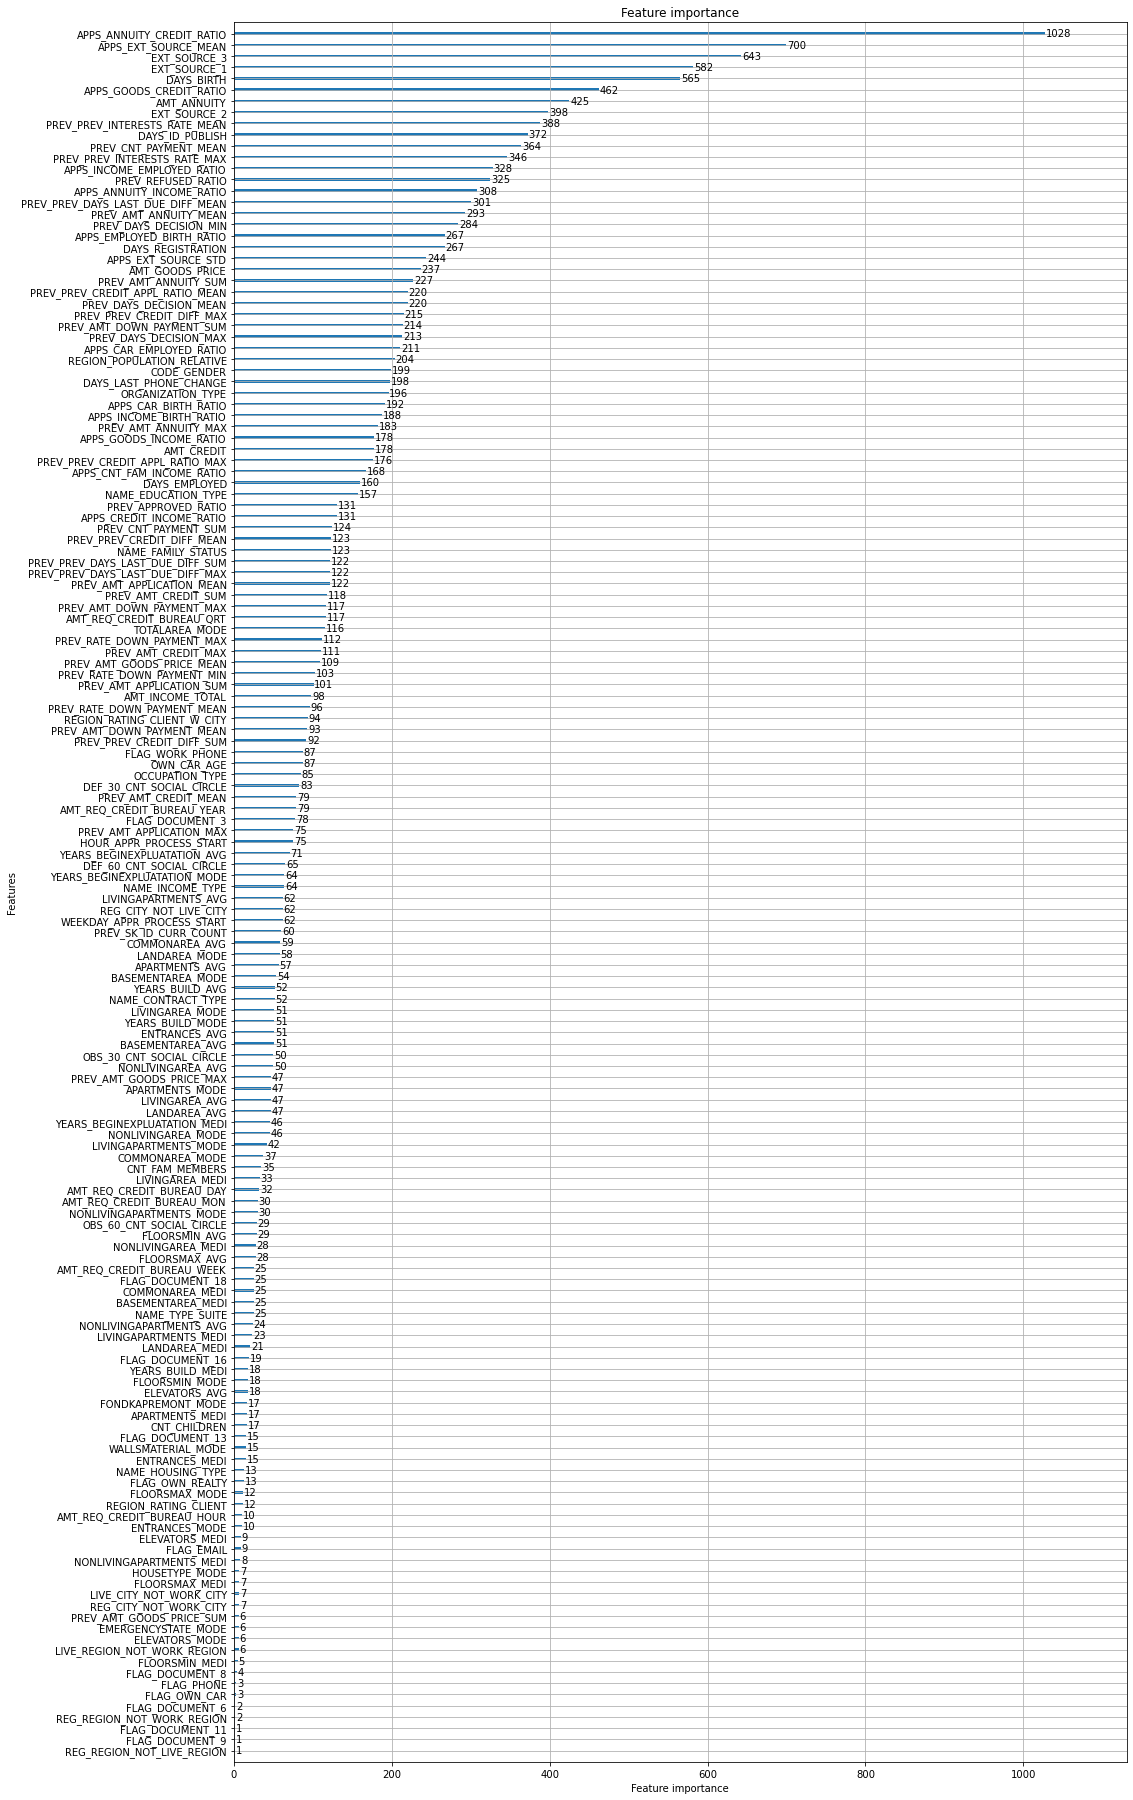

In [90]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

# PRED에서 만든 새로운 피처들이 1등은 아니지만 상위권에 MEAN , MAX등등 몇개가 들어간것을 알수 있다.
# 피처를 만드는 것은 특별한것이 아닌 관련있는 컬럼들을 비율과 평균 합으로 만든것 뿐이다.
# 이후에 그래프로 봤을때 관련이 있는지 확인해보는 것이다.

#### 학습된 Classifier를 이용하여 테스트 데이터 예측하고 결과를 Kaggle로 Submit 수행. 

In [92]:
preds = clf.predict_proba(apps_all_test.drop(s'SK_ID_CURR', axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds

ValueError: Number of features of the model must match the input. Model n_features_ is 174 and input n_features is 175

In [93]:
preds

array([0.02883339, 0.09603633, 0.01552571, ..., 0.01585729, 0.08026556,
       0.20690006])

In [74]:

apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv('prev_baseline_01.csv', index=False)

In [ ]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
    
    

##### 코랩 버전은 Google Drive로 예측 결과 CSV를 생성.

In [ ]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

In [ ]:
# SK_ID_CURR과 TARGET 값만 csv 형태로 생성. 코랩 버전은 구글 드라이브 절대 경로로 입력  
default_dir = "/content/gdrive/My Drive"
app_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(default_dir,'prev_baseline_01.csv'), index=False)

#### 지금까지 만든 로직을 별도의 함수로 생성. 

In [14]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# 신청금액과 실제 대출액, 상품금액과의 차이 비율, 만기일 차이 비교, 이자율 계산등의 주요 컬럼 가공 생산. 
def get_prev_processed(prev):
    # 대출 신청 금액과 실제 대출액/대출 상품금액 차이 및 비율
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']
    
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # 첫번째 만기일과 마지막 만기일까지의 기간
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    # 매월 납부 금액과 납부 횟수 곱해서 전체 납부 금액 구함. 
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    # 전체 납부 금액 대비 AMT_CREDIT 비율을 구하고 여기에 다시 납부횟수로 나누어서 이자율 계산. 
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
        
    return prev

# 기존 컬럼및 위에서 가공된 신규 컬럼들에 대해서 SK_ID_CURR 레벨로 Aggregation 수행.  
def get_prev_amt_agg(prev):

    agg_dict = {
         # 기존 주요 컬럼들을 SK_ID_CURR 레벨로 Aggregation 수행. . 
        'SK_ID_CURR':['count'],
        'AMT_CREDIT':['mean', 'max', 'sum'],
        'AMT_ANNUITY':['mean', 'max', 'sum'], 
        'AMT_APPLICATION':['mean', 'max', 'sum'],
        'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
        'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        # 신규 가공 컬럼들을 SK_ID_CURR 레벨로 Aggregation 수행. .
        'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
        'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
        'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO':['mean', 'max'],
        'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
        'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
    
    # 'SK_ID_CURR'로 조인하기 위해 SK_ID_CURR을 컬럼으로 변환  
    prev_amt_agg = prev_amt_agg.reset_index()
    
    return prev_amt_agg

# NAME_CONTRACT_STATUS의 SK_ID_CURR별 Approved, Refused의 건수 계산.  
def get_prev_refused_appr_agg(prev):
    # 원래 groupby 컬럼 + 세부 기준 컬럼으로 groupby 수행. 세분화된 레벨로 aggregation 수행 한 뒤에 unstack()으로 컬럼레벨로 변형. 
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
    # 컬럼명 변경. 
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
    # NaN값은 모두 0으로 변경. 
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
    
    # 'SK_ID_CURR'로 조인하기 위해 SK_ID_CURR을 컬럼으로 변환  
    prev_refused_appr_agg = prev_refused_appr_agg.reset_index()
    
    return prev_refused_appr_agg

    
# 앞에서 구한 prev_amt_agg와 prev_refused_appr_agg를 조인하고 SK_ID_CURR별 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성
def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    
    # prev_amt_agg와 조인. 
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성. 
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

# apps와 previous 데이터 세트를 SK_ID_CURR레벨로 다양한 컬럼이 aggregation되어 있는 prev_agg 조인
def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

# Label 인코딩 수행. 
def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

# 학습 데이터와 테스트 데이터 세트 분리. 
def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]

    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test

# 학습 수행. 
def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
            n_jobs=-1,
            n_estimators=1000,
            learning_rate=0.02,
            num_leaves=32,
            subsample=0.8,
            max_depth=12,
            silent=-1,
            verbose=-1,
            
                )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)
    
    return clf

##### 함수를 호출하여 재학습 및 평가 

In [15]:
apps_all = get_apps_all_with_prev_agg(apps, prev)
apps_all = get_apps_all_encoded(apps_all)
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)
clf = train_apps_all(apps_all_train)


prev_agg shape: (338857, 42)
apps_all before merge shape: (356255, 135)
apps_all after merge with prev_agg shape: (356255, 176)
train shape: (215257, 174) valid shape: (92254, 174)
[100]	training's auc: 0.766589	training's binary_logloss: 0.245898	valid_1's auc: 0.753688	valid_1's binary_logloss: 0.248717
[200]	training's auc: 0.78916	training's binary_logloss: 0.237745	valid_1's auc: 0.765764	valid_1's binary_logloss: 0.24412
[300]	training's auc: 0.804615	training's binary_logloss: 0.23241	valid_1's auc: 0.770737	valid_1's binary_logloss: 0.242391
[400]	training's auc: 0.817089	training's binary_logloss: 0.228151	valid_1's auc: 0.772765	valid_1's binary_logloss: 0.241665
[500]	training's auc: 0.82915	training's binary_logloss: 0.224266	valid_1's auc: 0.773429	valid_1's binary_logloss: 0.241421
[600]	training's auc: 0.839882	training's binary_logloss: 0.220713	valid_1's auc: 0.773558	valid_1's binary_logloss: 0.241337
[700]	training's auc: 0.849389	training's binary_logloss: 0.217359	

In [17]:
clf.predict_proba(apps_all_test.drop(['SK_ID_CURR'], axis=1))[:, 1 ]

array([[0.97518421, 0.02481579],
       [0.90564562, 0.09435438],
       [0.98666145, 0.01333855],
       ...,
       [0.98568203, 0.01431797],
       [0.91908514, 0.08091486],
       [0.81475253, 0.18524747]])

In [ ]:
preds = clf.predict_proba(apps_all_test.drop(['SK_ID_CURR'], axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv('prev_baseline_03.csv', index=False)

## 지금까지 만든 로직을 별도의 함수로 생성.


In [115]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
# 신청금액과 실제 대출액, 상품금액과의 차이 비율, 만기일 차이 비교, 이자율 계산등의 주요 컬럼 가공 생산.
def get_prev_processed(prev):
    # 대출 신청 금액과 실제 대출액/대출 상품금액 차이 및 비율
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']
    
    
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # 첫번째 만기일과 마지막 만기일까지의 기간
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    # 매월 납부 금액과 납부 횟수 곱해서 전체 납부 금액 구함.
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    # 전체 납부 금액 대비 AMT_CREDIT 비율을 구하고 여기에 다시 납부횟수로 나누어서 이자율 계산.
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
    
    return prev


# 기존 컬럼및 위에서 가공된 신규 컬럼들에 대해서 SK_ID_CURR 레벨로 Aggregation 수행.
def get_prev_amt_agg(prev):
    
    agg_dict = {
        # 기존 주요 컬럼들을 SK_ID_CURR 레벨로 Aggregation 수행. .
        'SK_ID_CURR':['count'],
        'AMT_CREDIT':['mean', 'max', 'sum'],
        'AMT_ANNUITY':['mean', 'max', 'sum'],
        'AMT_APPLICATION':['mean', 'max', 'sum'],
        'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
        'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        # 신규 가공 컬럼들을 SK_ID_CURR 레벨로 Aggregation 수행. .
        'PREV_CREDIT_DIFF':['mean', 'max', 'sum'],
        'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
        'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO':['mean', 'max'],
        'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
        'PREV_INTERESTS_RATE':['mean', 'max']
        }
    
    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)
    
    # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
    
    # 'SK_ID_CURR'로 조인하기 위해 SK_ID_CURR을 컬럼으로 변환
    prev_amt_agg = prev_amt_agg.reset_index()
    
    return prev_amt_agg

# NAME_CONTRACT_STATUS의 SK_ID_CURR별 Approved, Refused의 건수 계산.
def get_prev_refused_appr_agg(prev):
    # 원래 groupby 컬럼 + 세부 기준 컬럼으로 groupby 수행. 세분화된 레벨로 aggregation 수행 한 뒤에 unstack()으로 컬럼레벨로 변형.
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()  #함수를 호출하여 재학습 및 평가
                                                                                                        
    # 컬럼명 변경.
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
                                                                                                        
    # NaN값은 모두 0으로 변경.
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
                                                                                                        
    # 'SK_ID_CURR'로 조인하기 위해 SK_ID_CURR을 컬럼으로 변환
    prev_refused_appr_agg = prev_refused_appr_agg.reset_index()
                                                                                                        
    return prev_refused_appr_agg
                                                                                                        
# 앞에서 구한 prev_amt_agg와 prev_refused_appr_agg를 조인하고 SK_ID_CURR별 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성
def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
                                                                                                        
    # prev_amt_agg와 조인.
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
                                                                                                        
    # SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성.
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
                                                                                                        
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
                                                                                                        
    return prev_agg
                                                                                                        
# apps와 previous 데이터 세트를 SK_ID_CURR레벨로 다양한 컬럼이 aggregation되어 있는 prev_agg 조인
def get_apps_all_with_prev_agg(apps, prev):
    apps_all = get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
                                                                                                        
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
                                                                                                        
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
                                                                                                        
    return apps_all
                                                                                                        
# Label 인코딩 수행.
def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    return apps_all
                                                                                                        
                                                                                                        
# .학습 데이터와 테스트 데이터 세트 분리
def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]
                                                                                                        
    apps_all_test = apps_all_test.drop('TARGET', axis=1)
                                                                                                        
    return apps_all_train, apps_all_test
# 학습 수행.
def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']
                                                                                                        
    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
                                                                                                        
    clf = LGBMClassifier(
            n_jobs=-1,
            n_estimators=1000,
            learning_rate=0.02,
            num_leaves=32,
            subsample=0.8,
            max_depth=12,
            silent=-1,
            verbose=-1
            )
                                                                                                        
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)
    return clf

### 함수를 호출하여 재학습 및 평가


In [120]:
apps_all = get_apps_all_with_prev_agg(apps, prev)
apps_all = get_apps_all_encoded(apps_all)
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)
clf = train_apps_all(apps_all_train)


prev_agg shape: (338857, 42)
apps_all before merge shape: (356255, 135)
apps_all after merge with prev_agg shape: (356255, 176)
train shape: (215257, 174) valid shape: (92254, 174)
[100]	training's auc: 0.766589	training's binary_logloss: 0.245898	valid_1's auc: 0.753688	valid_1's binary_logloss: 0.248717
[200]	training's auc: 0.78916	training's binary_logloss: 0.237745	valid_1's auc: 0.765764	valid_1's binary_logloss: 0.24412
[300]	training's auc: 0.804615	training's binary_logloss: 0.23241	valid_1's auc: 0.770737	valid_1's binary_logloss: 0.242391
[400]	training's auc: 0.817089	training's binary_logloss: 0.228151	valid_1's auc: 0.772765	valid_1's binary_logloss: 0.241665
[500]	training's auc: 0.82915	training's binary_logloss: 0.224266	valid_1's auc: 0.773429	valid_1's binary_logloss: 0.241421
[600]	training's auc: 0.839882	training's binary_logloss: 0.220713	valid_1's auc: 0.773558	valid_1's binary_logloss: 0.241337
[700]	training's auc: 0.849389	training's binary_logloss: 0.217359	

In [18]:
apps_all_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APPS_EXT_SOURCE_MEAN,APPS_EXT_SOURCE_STD,APPS_ANNUITY_CREDIT_RATIO,APPS_GOODS_CREDIT_RATIO,APPS_ANNUITY_INCOME_RATIO,APPS_CREDIT_INCOME_RATIO,APPS_GOODS_INCOME_RATIO,APPS_CNT_FAM_INCOME_RATIO,APPS_EMPLOYED_BIRTH_RATIO,APPS_INCOME_EMPLOYED_RATIO,APPS_INCOME_BIRTH_RATIO,APPS_CAR_BIRTH_RATIO,APPS_CAR_EMPLOYED_RATIO,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_RATIO,PREV_APPROVED_RATIO
307511,100001,0,1,0,0,0,135000.0,568800.0,20560.5,450000.0,0,0,1,1,0,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,-1,2.0,2,2,6,18,0,0,0,0,0,0,13,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,-1,0,0.0392,0,0,0.0,0.0,0.0,0.0,-1740.0,

In [123]:

preds = clf.predict_proba(apps_all_test.drop(['SK_ID_CURR'], axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv('prev_baseline_03.csv', index=False)

In [124]:
preds

array([0.02481579, 0.09435438, 0.01333855, ..., 0.01431797, 0.08091486,
       0.18524747])

In [125]:
apps_all_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APPS_EXT_SOURCE_MEAN,APPS_EXT_SOURCE_STD,APPS_ANNUITY_CREDIT_RATIO,APPS_GOODS_CREDIT_RATIO,APPS_ANNUITY_INCOME_RATIO,APPS_CREDIT_INCOME_RATIO,APPS_GOODS_INCOME_RATIO,APPS_CNT_FAM_INCOME_RATIO,APPS_EMPLOYED_BIRTH_RATIO,APPS_INCOME_EMPLOYED_RATIO,APPS_INCOME_BIRTH_RATIO,APPS_CAR_BIRTH_RATIO,APPS_CAR_EMPLOYED_RATIO,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_RATIO,PREV_APPROVED_RATIO,TARGET
307511,100001,0,1,0,0,0,135000.0,568800.0,20560.5,450000.0,0,0,1,1,0,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,-1,2.0,2,2,6,18,0,0,0,0,0,0,13,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0514,NaN,NaN,-1,0,0.0392,0,0,0.0,0.0,0.0,0.